# first tests for optimization

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

try:
    import dolfin as dl
    using_firedrake = False
except ImportError:
    import firedrake as dl
    using_firedrake = True
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Parameter class not available


In [2]:
tStart_notebook = time.time()

## User settings

In [3]:
meshDim = 50 
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 2
n_search = 50

eval_mode = "point-eval" # because it's faster for testing code
dt = 0.001

## Setup

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
fom_transient = FOM_advectiondiffusion(meshDim=meshDim, dt=dt, final_time=1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.000447584s, CPU 0.000634s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0490528s, CPU 0.048277s)
Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 1.72923e-05s, CPU 9e-06s)
Info    : 2953 nodes 5920 elements
Info    : Writing 'houses.msh'...
Info    : Done writing 'houses.msh'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info

In [5]:
para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_transient, grid_t = fom.implicit_Euler(m_init=m, dt=dt, final_time=1)
sol_steadystate = fom.solve_steady(forcing=m)

In [6]:
# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

drone = Drone(fom, grid_t=grid_t, flying_parameters=flying_parameters, eval_mode=eval_mode)
pos, __ = drone.get_trajectory(grid_t=grid_t, flying_parameters=flying_parameters)

In [7]:
prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))

noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01, noise_seed=42)
noise_model_transient = NoiseModel(grid_t=grid_t, c_scaling=1e+1, c_diffusion = 0.01, noise_seed=42)

brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
brain_transient = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model_transient)

In [8]:
print("just for testing:")

post_steadystate = brain.compute_posterior()
print("steady-state mean: ", post_steadystate.mean)

post_transient = brain_transient.compute_posterior()
print("transient mean:    ", post_transient.mean)

print("steady-state:")
print("A-OED:", brain.eval_utility(post_steadystate, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_steadystate, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_steadystate, oed_mode="E"), "\n")

print("transient:")
print("A-OED:", brain.eval_utility(post_transient, oed_mode="A"))
print("D-OED:", brain.eval_utility(post_transient, oed_mode="D"))
print("E-OED:", brain.eval_utility(post_transient, oed_mode="E"), "\n")

just for testing:


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


steady-state mean:  None


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


transient mean:     None
steady-state:
A-OED: 1.80278391672502
D-OED: 0.8029460624197043
E-OED: 0.9991743707938694 

transient:
A-OED: 1.997553840646
D-OED: 0.9975538607904495
E-OED: 0.9999917369539486 



/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


## grid search

### radius

In [9]:
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4]))
radius_max = la.norm(np.array([0, 0.55])/2)

search_grid = np.linspace(radius_min, radius_max, n_search)
util_steadystate = np.zeros((n_search, 3))
util_transient = np.zeros((n_search, 3))

for i in range(n_search):
    print("iteration {} / {}".format(i+1, n_search))
    
    flying_parameters = {
                "radius" : search_grid[i],
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

    drone.set_default_flying_parameters(flying_parameters)
    
    post_steadystate = brain.compute_posterior()
    post_transient = brain_transient.compute_posterior()
    
    util_steadystate[i, 0] = brain.eval_utility(post_steadystate, oed_mode="A")
    util_steadystate[i, 1] = brain.eval_utility(post_steadystate, oed_mode="D")
    util_steadystate[i, 2] = brain.eval_utility(post_steadystate, oed_mode="E")
    
    util_transient[i, 0] = brain.eval_utility(post_transient, oed_mode="A")
    util_transient[i, 1] = brain.eval_utility(post_transient, oed_mode="D")
    util_transient[i, 2] = brain.eval_utility(post_transient, oed_mode="E")

iteration 1 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 2 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 3 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 4 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 5 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 6 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 7 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 8 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 9 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 10 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 11 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 12 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 13 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 14 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 15 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 16 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 17 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 18 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 19 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 20 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 21 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 22 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 23 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 24 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 25 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 26 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 27 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 28 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 29 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 30 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 31 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 32 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 33 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 34 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 35 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 36 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 37 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 38 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 39 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 40 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 41 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 42 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 43 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 44 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 45 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 46 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 47 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 48 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 49 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 50 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


Optimal radius:
A-OED, steady-state: 0.275
A-OED, transient:    0.275
D-OED, steady-state: 0.275
D-OED, transient:    0.275
E-OED, steady-state: 0.18078580977432518
E-OED, transient:    0.18078580977432518


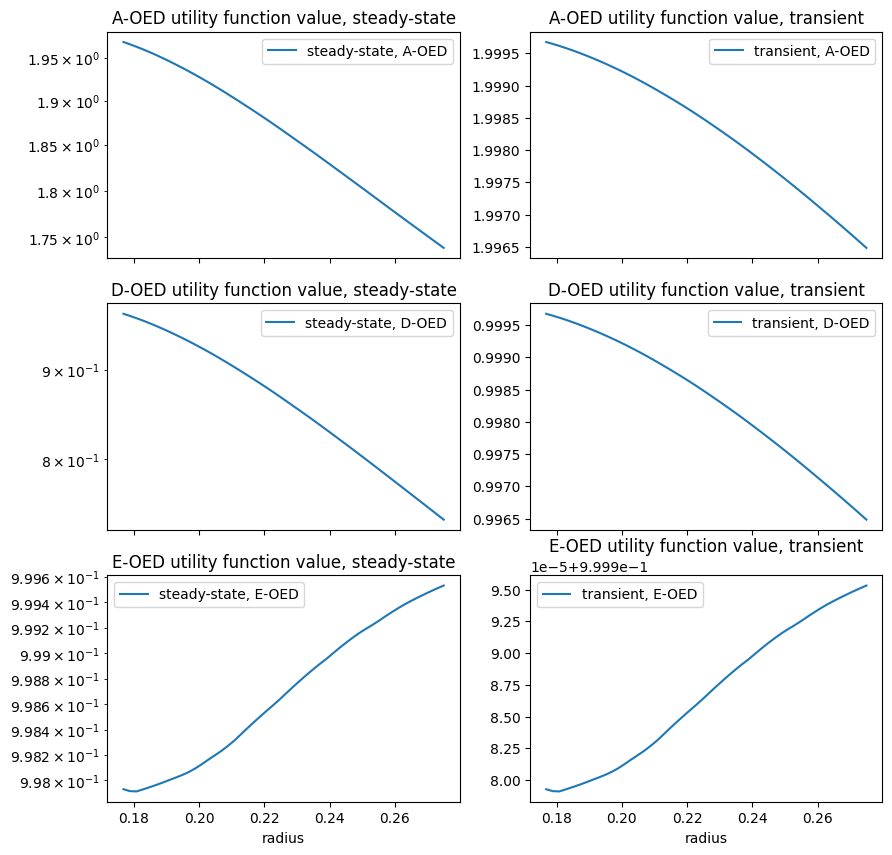

In [10]:
util_names = ["A", "D", "E"]
fig, axs = plt.subplots(3, 2, sharex = True, figsize = (10, 10))

for i in range(3):
    axs[i, 0].semilogy(search_grid, util_steadystate[:, i], label="steady-state, {}-OED".format(util_names[i]))
    axs[i, 1].plot(search_grid, util_transient[:, i], label="transient, {}-OED".format(util_names[i]))
    
    axs[i, 0].legend()
    axs[i, 0].set_title("{}-OED utility function value, steady-state".format(util_names[i]))
    
    axs[i, 1].legend()
    axs[i, 1].set_title("{}-OED utility function value, transient".format(util_names[i]))
    
axs[-1, 0].set_xlabel("radius")
axs[-1, 1].set_xlabel("radius")

print("Optimal radius:")
print("A-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 0])])
print("A-OED, transient:   ", search_grid[np.argmin(util_transient[:, 0])])

print("D-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 1])])
print("D-OED, transient:   ", search_grid[np.argmin(util_transient[:, 1])])

print("E-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 2])])
print("E-OED, transient:   ", search_grid[np.argmin(util_transient[:, 2])])

### speed

In [11]:
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4]))
radius_max = la.norm(np.array([0, 0.55])/2)

# radius = (radius_min + radius_max)/2
radius = 0.2
round_trip_time_min = 1
round_trip_time_max = 8

speed_min = (2 * np.pi * radius) / round_trip_time_max
speed_max = (2 * np.pi * radius) / round_trip_time_min

search_grid = np.linspace(speed_min, speed_max, n_search)
util_steadystate = np.zeros((n_search, 3))
util_transient = np.zeros((n_search, 3))

for i in range(n_search):
    print("iteration {} / {}".format(i+1, n_search))
    
    flying_parameters = {
                "radius" : radius,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : search_grid[i]
            }

    drone.set_default_flying_parameters(flying_parameters)
    
    post_steadystate = brain.compute_posterior()
    post_transient = brain_transient.compute_posterior()
    
    util_steadystate[i, 0] = brain.eval_utility(post_steadystate, oed_mode="A")
    util_steadystate[i, 1] = brain.eval_utility(post_steadystate, oed_mode="D")
    util_steadystate[i, 2] = brain.eval_utility(post_steadystate, oed_mode="E")
    
    util_transient[i, 0] = brain.eval_utility(post_transient, oed_mode="A")
    util_transient[i, 1] = brain.eval_utility(post_transient, oed_mode="D")
    util_transient[i, 2] = brain.eval_utility(post_transient, oed_mode="E")

iteration 1 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 2 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 3 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 4 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 5 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 6 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 7 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 8 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 9 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 10 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 11 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 12 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 13 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 14 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 15 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 16 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 17 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 18 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 19 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 20 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 21 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 22 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 23 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 24 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 25 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 26 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 27 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 28 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 29 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 30 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 31 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 32 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 33 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 34 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 35 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 36 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 37 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 38 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 39 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 40 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 41 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 42 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 43 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 44 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 45 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 46 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 47 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 48 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 49 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


iteration 50 / 50


/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):
/Users/tlynn/Code/firedrake/firedrake/src/ufl/ufl/exproperators.py:323: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if arg in ("+", "-"):


Optimal speed:
A-OED, steady-state: 0.5609986881410345
A-OED, transient:    0.5609986881410345
D-OED, steady-state: 0.5609986881410345
D-OED, transient:    0.5609986881410345
E-OED, steady-state: 1.2566370614359172
E-OED, transient:    1.2566370614359172


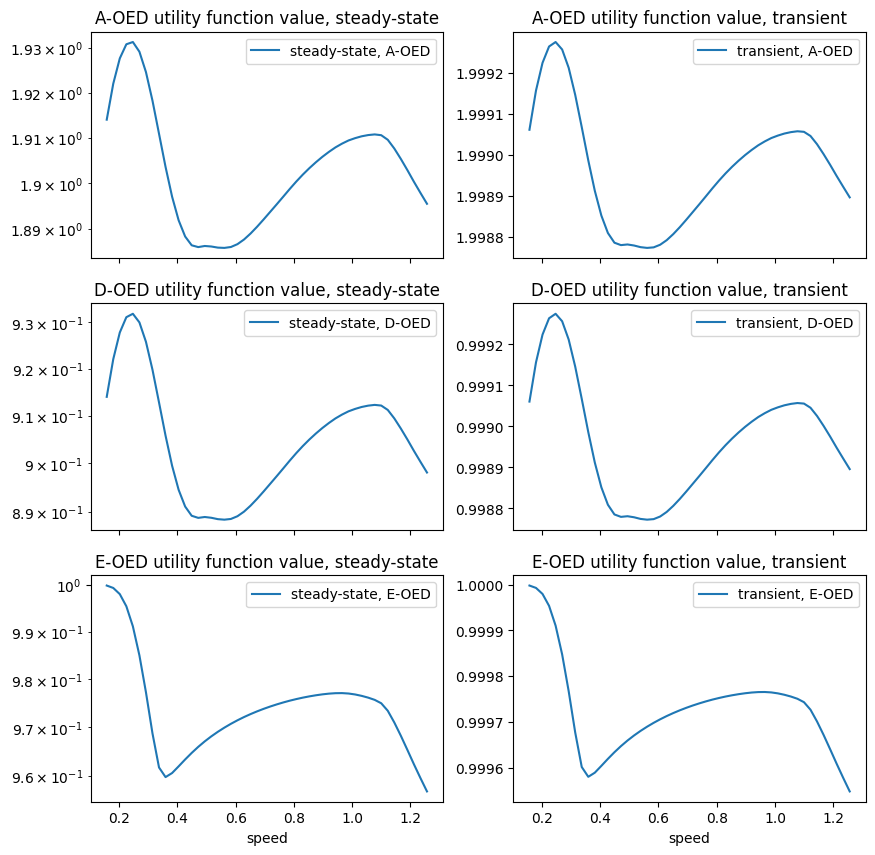

In [12]:
util_names = ["A", "D", "E"]
fig, axs = plt.subplots(3, 2, sharex = True, figsize = (10, 10))

for i in range(3):
    axs[i, 0].semilogy(search_grid, util_steadystate[:, i], label="steady-state, {}-OED".format(util_names[i]))
    axs[i, 1].plot(search_grid, util_transient[:, i], label="transient, {}-OED".format(util_names[i]))
    
    axs[i, 0].legend()
    axs[i, 0].set_title("{}-OED utility function value, steady-state".format(util_names[i]))
    
    axs[i, 1].legend()
    axs[i, 1].set_title("{}-OED utility function value, transient".format(util_names[i]))
    
axs[-1, 0].set_xlabel("speed")
axs[-1, 1].set_xlabel("speed")

print("Optimal speed:")
print("A-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 0])])
print("A-OED, transient:   ", search_grid[np.argmin(util_transient[:, 0])])

print("D-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 1])])
print("D-OED, transient:   ", search_grid[np.argmin(util_transient[:, 1])])

print("E-OED, steady-state:", search_grid[np.argmin(util_steadystate[:, 2])])
print("E-OED, transient:   ", search_grid[np.argmin(util_transient[:, 2])])

In [13]:
speed_min

0.15707963267948966

In [16]:
speed_max

1.2566370614359172

In [15]:
radius

0.2